# Image segmentation with a U-Net-like architecture

**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Getting started
First, we check the version of Tensorflow and set the seeds for reproducibility.

Las mascaras tienen 3 clases:

    Clase 1: Pixel perteneciente a la mascota.
    Clase 2: Pixel al borde de la mascota.
    Clase 3: Ninguno de los píxeles anteriores / circundantes.

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

seed = 42
img_size = (256,256) #gt_image size, and network output size
num_classes = 3

down_factor = 4
data_augmentation = True
BATCH_SIZE = 1
preprocess_data = True # turn False if you have ready your data

downscale_img_size = (img_size[0]//down_factor, img_size[1]//down_factor)
up_factor = down_factor
def set_seed(seedValue=42):
  """Sets the seed on multiple python modules to obtain results as
  reproducible as possible.
  Args:
  seedValue (int, optional): seed value.
  """
  np.random.seed(seed=seedValue)
  tf.random.set_seed(seedValue)
  os.environ["PYTHONHASHSEED"]=str(seedValue)
  random.seed(seedValue)
set_seed(seed)
print("Tensorflow version: ", tf.__version__ )

Tensorflow version:  2.5.0


Download the data

In [3]:
import os
if not os.path.exists('./images.tar.gz'):
    !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    !tar -xf images.tar.gz
    !tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  20.0M      0  0:00:37  0:00:37 --:--:-- 21.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  7555k      0  0:00:02  0:00:02 --:--:-- 7555k


## Data modifications

Splits

Prepare paths of input images and target segmentation masks

In [4]:
import pandas as pd

filename = "annotations/trainval.txt"
train = pd.read_csv(filename, sep=' ',  names = ['names', 'class-id', 'specie', 'breed'], encoding="utf-8", skiprows=0)

filename = "annotations/test.txt"
test = pd.read_csv(filename, sep=' ',  names = ['names', 'class-id', 'specie', 'breed'], encoding="utf-8", skiprows=0)

#print(test)
#print(train)

In [5]:
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

input_dir = "images/"
target_dir = "annotations/trimaps/"

train_img_paths = []
test_img_paths = []

for i, fname in enumerate(train['names']):
    x = os.path.join(input_dir, fname + ".jpg")
    y = os.path.join(target_dir, fname + ".png")
    #c = train['class-id'][i]
    train_img_paths.append( (x,y) )
for i, fname in enumerate(test['names']):
    x = os.path.join(input_dir, fname + ".jpg")
    y = os.path.join(target_dir, fname + ".png")
    #c = train['class-id'][i]
    test_img_paths.append( (x,y) )

train_img_paths, val_img_paths = train_test_split(
    train_img_paths, 
    test_size=0.20,
    stratify= train['class-id'],
    random_state=42)

total_n_img = len(os.listdir(input_dir))
print("\nNumber of samples (train): {}  --  {}%".format( 
    len(train_img_paths), 
    round(( len(train_img_paths) * 100) / total_n_img )))
print("Number of samples (test): {}  --  {}%".format( 
    len(test_img_paths), 
    round(( len(test_img_paths) * 100) / total_n_img )))
print("Number of samples (val): {}  --  {}%".format( 
    len(val_img_paths), 
    round(( len(val_img_paths) * 100) / total_n_img )))



Number of samples (train): 2944  --  40%
Number of samples (test): 3669  --  50%
Number of samples (val): 736  --  10%


### Save modified images

In [6]:
from skimage import filters

def classic_crappify(img):
    im = np.asarray(img, dtype=np.float32)
    im = filters.gaussian(im, sigma=3, multichannel=True) + 1e-6 + 2e-7 #(salt and peper)
    im = np.rint(im)
    im = np.asarray(im, dtype=np.uint8)
    return Image.fromarray(im)

def sub1(mask):
    # [3,2,1] -> [2,1,0]
    m = np.asarray(mask, dtype=np.uint8) - 1
    return Image.fromarray(m)

In [7]:
from PIL import Image

# data
splits = [train_img_paths, val_img_paths, test_img_paths]

# out directory names
main_Dir= "./Data/"
dirNames=[main_Dir + "train/", main_Dir + "val/", main_Dir + "test/"]
data_type = ["gt_img/", "gt_mask/", "lr"+str(down_factor)+"_img/"]

if preprocess_data:
    for i, ds in enumerate(splits):
        outdir = dirNames[i]
        
        # create folders if not exist
        for folder in data_type:
            if not os.path.exists(outdir + folder):
                os.makedirs(outdir + folder)

        for img_path, mask_path in tqdm(ds):
            # Get file names
            image_name = img_path.split("/")[-1]
            mask_name = image_name[:-3] + "png"

            # Skip processed images
            if os.path.exists(outdir + data_type[2] + image_name):
                if Image.open(outdir + data_type[0] + image_name).size == img_size:
                    continue
            
            # Open images
            image = Image.open(img_path)
            mask = Image.open(mask_path)

            # Convert (RGBA,...) images to RGB
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Apply moddifications (crappify, resize, ...)
            gt_img = image.resize(img_size, Image.BILINEAR)
            gt_mask = sub1(mask).resize(img_size, Image.NEAREST)
            lr_img = classic_crappify(gt_img).resize(downscale_img_size, Image.BILINEAR)

            # Save images
            gt_img.save(outdir + data_type[0] + image_name, quality=100)
            gt_mask.save(outdir + data_type[1] + mask_name, quality=100)
            lr_img.save(outdir + data_type[2] + image_name, quality=100)

100%|██████████| 3669/3669 [01:08<00:00, 53.88it/s]


## Utilities 
(functions and classes)

### Data class
Prepare `Sequence` class to load & vectorize batches of data

In [8]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, down_factor = 4, data_augmentation=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.downscale_img_size = (img_size[0]//down_factor, img_size[1]//down_factor)
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")# mask
        
        for j in range(len(batch_input_img_paths)):
            x_path = batch_input_img_paths[j]
            y_path = batch_target_img_paths[j]

            x_image = Image.open(x_path)
            y_image = Image.open(y_path)

            if self.data_augmentation:
                if random.random() < 0.5:
                    x_image = x_image.transpose(method=Image.FLIP_LEFT_RIGHT)
                    y_image = y_image.transpose(method=Image.FLIP_LEFT_RIGHT)

            y_image = np.asarray(y_image, dtype=np.float32)

            x[j] = np.asarray(x_image, dtype=np.float32) / 255 # normalize x
            y[j] = np.expand_dims(y_image, 2)

        return x, y


### Functions to display

In [9]:
def plot_loss_and_metric(eval_metric, history):
    plt.figure(figsize=(14,5))

    if callable( eval_metric ):
        metric_name = eval_metric.__name__
    else:
        metric_name = eval_metric

    # summarize history for loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # summarize history for MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_'+metric_name])
    plt.title('model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [10]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):

  def __init__(self, display_raw_mask=False):
      self.display_raw_mask = display_raw_mask

  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(display_raw_mask = self.display_raw_mask)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Raw Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #plt.axis('off')
  plt.show()
  

In [12]:
def show_predictions(dataset=None, num=1, display_raw_mask = False, var=220):
    images = []
    if dataset:
        for i in range(num):
            ind = var * i
            image, mask = dataset[ind]
            pred_mask = model.predict(image)
            images = [image[0], mask[0], create_mask(pred_mask)]
            if display_raw_mask:
                images = images + [pred_mask[0]]
            display(images)
    else:
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        images = [sample_image, sample_mask, create_mask(pred_mask)]
        if display_raw_mask:
                images = images + [pred_mask[0]]
        display(images)

In [13]:
def create_mask(pred_mask, return_all = False):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  if return_all:
    return pred_mask
  return pred_mask[0]

### Others

One-cycle policy for super-convergence
We implement the learning rate on a one-cycle policy as per Leslie Smith's paper (https://arxiv.org/pdf/1803.09820.pdf) for fast convergence.

In [14]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """ `Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

#### jaccard function (IoU)

In [15]:
# dentro de la funcion da error
jaccard = tf.keras.metrics.MeanIoU(num_classes=num_classes) 

def jaccard_index(y_true, y_pred):
    """Define Jaccard index.
       Args:
            y_true (tensor): ground truth masks. (w, h, 1)
            y_pred (tensor): predicted masks. (w,h, num_classses)
       Return:
            jac (tensor): Jaccard index value
    """
    # argmax
    # (w,h,3) [0-1] values -> (w,h) [1,2,...,(num_classes)] classes
    y_pred = tf.math.argmax(y_pred, axis=-1) 

    # type int
    y_pred_ = tf.cast(y_pred, dtype=tf.uint8)
    y_true = tf.cast(y_true, dtype=tf.uint8)

    # flatten
    #y_pred = tf.reshape(y_pred, [-1])
    #y_true = tf.reshape(y_true, [-1])
    
    jaccard.reset_states() # clean
    jaccard.update_state(y_true, y_pred_) # compute
    jac = tf.cast(jaccard.result(), dtype=tf.float64) # get result

    return jac

In [16]:
### Comprobar si el IOU calculado es el correcto cogiendo 1 imagen de muestra
# si los dos valores iou imprimidos coinciden, es correcto

from sklearn.metrics import jaccard_score

def verify_iou(img=0, display_img=False, display_raw_mask = False):
    images = []
    image, mask = test_dataset[img] # take 1 batch
    predictions = model.predict(image)

    pred_mask = predictions[0]
    int_pred_mask = create_mask(pred_mask, return_all = True)
    real = np.asarray(mask[0], dtype='uint8').flatten()
    pred = np.asarray(int_pred_mask, dtype='uint8').flatten()

    if display_img:
        images = [image[0], mask[0], int_pred_mask]
    if display_raw_mask:
        images = images + [pred_mask]
    
    if display_img or display_raw_mask:
        display(images)

    jac_score = jaccard_score( real, pred, average='macro')
    jac_tf_score = jaccard_index(mask[0], pred_mask).numpy()

    print("sk IoU: ", jac_score)
    print("tf IoU: ", jac_tf_score)

## Prepare data

In [17]:
## out directory names
# data_type = ["gt_img/", "gt_mask/", "lr"+str(down_factor)+"_img/"]
from glob import glob

# Get paths
x_path = data_type[0]+ "*"
y_path = data_type[1]+ "*"

train_x_paths = glob(dirNames[0] + x_path)
train_y_paths = glob(dirNames[0] + y_path)
train_x_paths.sort()
train_y_paths.sort()

val_x_paths = glob(dirNames[1] + x_path)
val_y_paths = glob(dirNames[1] + y_path)
val_x_paths.sort()
val_y_paths.sort()

test_x_paths = glob(dirNames[2] + x_path)
test_y_paths = glob(dirNames[2] + y_path)
test_x_paths.sort()
test_y_paths.sort()

In [18]:
# data generator
train_dataset = OxfordPets( BATCH_SIZE, img_size, train_x_paths, train_y_paths, down_factor, data_augmentation)
test_dataset = OxfordPets( BATCH_SIZE, img_size, test_x_paths, test_y_paths, down_factor)
val_dataset = OxfordPets( BATCH_SIZE, img_size, val_x_paths, val_y_paths, down_factor)

### Display (x,y) image example
What does one downscaled input image and corresponding ground truth image look like?

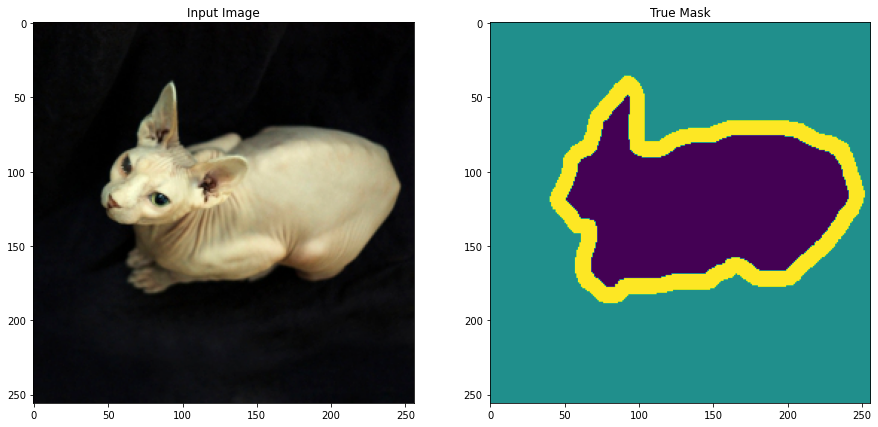

In [19]:
sample_image, sample_mask = train_dataset[911]
sample_image, sample_mask = sample_image[0], sample_mask[0] # first batch image
display([sample_image, sample_mask])

## Network definitions

### Res/UNet

Next, we define our U-Net-like networks. In particular, we define two type of architectures:
* `UNet` is a regular U-Net with 4 resolution levels in the contracting path, a bottleneck, and 4 resolution levels in the expanding path.
* `ResUNet` is a residual U-Net with a user-defined depth (number of levels + bottleneck).

In [22]:
# Network definitions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, UpSampling2D, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, SeparableConv2D, Conv1D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Concatenate, Add, concatenate, Lambda

# Regular U-Net
def UNet(input_size = (None,None,3),
         filters=16,
         activation='elu',
         kernel_initializer = 'he_normal',
         dropout_value=0.2,
         average_pooling=True,
         spatial_dropout=False,
         pixel_shuffle = False,
         num_classes = 3): # (animal, animal outline, other)
  """
  Create a U-Net for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            filters (int, optional): number of channels at the first level of U-Net
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
                initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
                level and the bottleneck
            average_pooling (bool, optional): use average-pooling between U-Net
                levels (otherwise use max pooling).
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
            num_classes (int): number of classes
       Returns:
            model (Keras model): model containing the ResUNet created.
  """
  # make a list of dropout values if needed
  if type( dropout_value ) is float:
            dropout_value = [dropout_value]*5

  inputs = Input( input_size )

  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(inputs)
  conv1 = SpatialDropout2D(dropout_value[0], seed=seed)(conv1) if spatial_dropout else Dropout(dropout_value[0], seed=seed) (conv1)
  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv1)
  pool1 = AveragePooling2D(pool_size=(2, 2))(conv1) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool1)
  conv2 = SpatialDropout2D(dropout_value[1], seed=seed)(conv2) if spatial_dropout else Dropout(dropout_value[1], seed=seed) (conv2)
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv2)
  pool2 = AveragePooling2D(pool_size=(2, 2))(conv2) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool2)
  conv3 = SpatialDropout2D(dropout_value[2], seed=seed)(conv3) if spatial_dropout else Dropout(dropout_value[2], seed=seed) (conv3)
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv3)
  pool3 = AveragePooling2D(pool_size=(2, 2))(conv3) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool3)
  conv4 = SpatialDropout2D(dropout_value[3], seed=seed)(conv4) if spatial_dropout else Dropout(dropout_value[3], seed=seed)(conv4)
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv4)
  pool4 = AveragePooling2D(pool_size=(2, 2))(conv4) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool4)
  conv5 = SpatialDropout2D(dropout_value[4], seed=seed)(conv5) if spatial_dropout else Dropout(dropout_value[4], seed=seed)(conv5)
  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv5)
  
  up6 = tf.nn.depth_to_space(conv5, 2) if pixel_shuffle else Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same') (conv5)  
  merge6 = concatenate([conv4,up6], axis = 3)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge6)
  conv6 = SpatialDropout2D(dropout_value[3], seed=seed)(conv6) if spatial_dropout else Dropout(dropout_value[3], seed=seed)(conv6)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv6)

  up7 = tf.nn.depth_to_space(conv6, 2) if pixel_shuffle else Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same') (conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge7)
  conv7 = SpatialDropout2D(dropout_value[2], seed=seed)(conv7) if spatial_dropout else Dropout(dropout_value[2], seed=seed)(conv7)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv7)
  
  up8 = tf.nn.depth_to_space(conv7, 2) if pixel_shuffle else Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same') (conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge8)
  conv8 = SpatialDropout2D(dropout_value[1], seed=seed)(conv8) if spatial_dropout else Dropout(dropout_value[1], seed=seed)(conv8)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv8)
  
  up9 = tf.nn.depth_to_space(conv8, 2) if pixel_shuffle else Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same') (conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge9)
  conv9 = SpatialDropout2D(dropout_value[0], seed=seed)(conv9) if spatial_dropout else Dropout(dropout_value[0], seed=seed)(conv9)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv9)

  outputs = Conv2D( 
                num_classes ,
                (1, 1),
                #3,
                #activation="sigmoid",
                padding='same'
                ) (conv9)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  return model


# == Residual U-Net ==

def residual_block(x, dim, filter_size, activation='elu', 
                   kernel_initializer='he_normal', dropout_value=0.2, bn=False,
                   separable_conv=False, firstBlock=False, spatial_dropout=False):

    # Create shorcut
    shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=1)(x)
    
    # Main path
    if firstBlock == False:
        x = BatchNormalization()(x) if bn else x
        x = Activation( activation )(x)
    if separable_conv == False or firstBlock:
        x = Conv2D(dim, filter_size, strides=1, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, strides=1, 
                            activation=None, kernel_initializer=kernel_initializer,
                            padding='same') (x)
    if dropout_value:
        x = SpatialDropout2D( dropout_value, seed=seed ) (x) if spatial_dropout else Dropout( dropout_value, seed=seed ) (x)
    x = BatchNormalization()(x) if bn else x
    x = Activation( activation )(x)
      
    if separable_conv == False:
        x = Conv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)

    # Add shortcut value to main path
    x = Add()([shortcut, x])
    return x

def level_block(x, depth, dim, fs, ac, k, d, bn, sc, fb, ap, spatial_dropout, ps):
    do = d[depth] if d is not None else None
    if depth > 0:
        r = residual_block(x, dim, fs, ac, k, do, bn, sc, fb, spatial_dropout)
        x = AveragePooling2D((2, 2)) (r) if ap else MaxPooling2D((2, 2)) (r)
        x = level_block(x, depth-1, (dim*2), fs, ac, k, d, bn, sc, False, ap, spatial_dropout, ps) 
        x = tf.nn.depth_to_space(x, 2) if ps else  Conv2DTranspose(dim, (2, 2), strides=(2, 2), padding='same') (x)
        x = Concatenate()([r, x])
        x = residual_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    else:
        x = residual_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    return x


def ResUNet( input_size=(None, None, 3), activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, average_pooling=False, separable=False,
            filters=16, depth=4, spatial_dropout=False, long_shortcut=True,
            pixel_shuffle=False, num_classes = 3): 
            # (animal, animal outline, other)

    """Create a Residual U-Net for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
            level and the bottleneck
            batchnorm (bool, optional): use batch normalization
            average_pooling (bool, optional): use average-pooling between U-Net levels 
            (otherwise use max pooling).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            filters (int, optional): number of channels at the first level of U-Net
            depth (int, optional): number of U-Net levels
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
            long_shortcut (bool, optional): add long shorcut from input to output.
            num_classes (int): number of classes
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input( input_size )
    #print( 'input shape: '+ str(inputs.shape) )
    if dropout_value is not None:
        if type( dropout_value ) is float:
            dropout_value = [dropout_value]*(depth+1)
        else:
            dropout_value.reverse() # reverse list to go from top to down

    x = level_block(inputs, depth, filters, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, separable, True, average_pooling,
                    spatial_dropout, pixel_shuffle)

    if long_shortcut:       
        #x = Concatenate()([inputs, x])

        # for adding, the same shape is needed
        inp = Conv2D(x.shape[-1], activation=None, kernel_size=(1, 1), 
                      strides=1, kernel_initializer=kernel_initializer, padding='same')(inputs)
        # https://stats.stackexchange.com/questions/361018/when-to-add-layers-and-when-to-concatenate-in-neural-networks
        x = Add()([inp, x]) # long shortcut

    outputs = Conv2D( 
                num_classes,
                (1, 1), #last kernel size
                #3,     #last kernel size
                #activation="sigmoid",
                padding='same'
                ) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


### RCAN

In [23]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Add, Lambda, GlobalAveragePooling2D, Multiply, Dense, Reshape
from tensorflow.keras.models import Model

import sys
sys.setrecursionlimit(10000)


def sub_pixel_conv2d(scale=2, **kwargs):
    return Lambda(lambda x: tf.nn.depth_to_space(x, scale), **kwargs)


def upsample(input_tensor, filters):
    x = Conv2D(filters=filters * 4, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = sub_pixel_conv2d(scale=2)(x)
    x = Activation('relu')(x)
    return x


def ca(input_tensor, filters, reduce=16):
    x = GlobalAveragePooling2D()(input_tensor)
    x = Reshape((1, 1, filters))(x)
    x = Dense(filters/reduce,  activation='relu', kernel_initializer='he_normal', use_bias=False)(x)
    x = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)
    x = Multiply()([x, input_tensor])
    return x


def rcab(input_tensor, filters, scale=0.1):
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = ca(x, filters)
    if scale:
        x = Lambda(lambda t: t * scale)(x)
    x = Add()([x, input_tensor])

    return x


def rg(input_tensor, filters, n_rcab=20):
    x = input_tensor
    for _ in range(n_rcab):
        x = rcab(x, filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x, input_tensor])

    return x


def rir(input_tensor, filters, n_rg=10):
    x = input_tensor
    for _ in range(n_rg):
        x = rg(x, filters=filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x, input_tensor])

    return x


def rcan(filters=64, n_sub_block=2, out_channels=1, input_size=(None,None,3)):
    inputs = Input(shape=input_size)

    x = x_1 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(inputs)
    x = rir(x, filters=filters)
    x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x)
    x = Add()([x_1, x])

    #for _ in range(n_sub_block):
    #    x = upsample(x, filters)
    #x = Conv2D(filters=out_channels, kernel_size=3, strides=1, padding='same')(x)

    outputs = Conv2D(out_channels, (1, 1), padding='same') (x)

    return Model(inputs=inputs, outputs=outputs)

### Res-CAUNet

In [24]:
# == Residual U-Net ==

def resCA_block(x, dim, filter_size, activation='elu', 
                   kernel_initializer='he_normal', dropout_value=0.2, bn=False,
                   separable_conv=False, firstBlock=False, spatial_dropout=False):

    # Create shorcut
    shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=1)(x)
    
    # Main path
    if firstBlock == False:
        x = BatchNormalization()(x) if bn else x
        x = Activation( activation )(x)
    if separable_conv == False or firstBlock:
        x = Conv2D(dim, filter_size, strides=1, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, strides=1, 
                            activation=None, kernel_initializer=kernel_initializer,
                            padding='same') (x)
    if dropout_value:
        x = SpatialDropout2D( dropout_value, seed=seed ) (x) if spatial_dropout else Dropout( dropout_value, seed=seed ) (x)
    x = BatchNormalization()(x) if bn else x
    x = Activation( activation )(x)
      
    if separable_conv == False:
        x = Conv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)

    # channel attention
    x = ca(x, dim)

    # Add shortcut value to main path
    x = Add()([shortcut, x])
    return x

def level_block_CA(x, depth, dim, fs, ac, k, d, bn, sc, fb, ap, spatial_dropout, ps):
    do = d[depth] if d is not None else None
    if depth > 0:
        r = resCA_block(x, dim, fs, ac, k, do, bn, sc, fb, spatial_dropout)
        x = AveragePooling2D((2, 2)) (r) if ap else MaxPooling2D((2, 2)) (r)
        x = level_block_CA(x, depth-1, (dim*2), fs, ac, k, d, bn, sc, False, ap, spatial_dropout, ps) 
        x = tf.nn.depth_to_space(x, 2) if ps else  Conv2DTranspose(dim, (2, 2), strides=(2, 2), padding='same') (x)
        x = Add()([r, x])## Orig: Concat
        x = resCA_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    else:
        x = resCA_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    return x


def ResCAUNet( input_size=(None, None, 3), activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, average_pooling=False, separable=False,
            filters=16, depth=4, spatial_dropout=False, long_shortcut=True,
            pixel_shuffle=False, num_classes = 3): 
            # (animal, animal outline, other)

    """Create a Residual U-Net for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
            level and the bottleneck
            batchnorm (bool, optional): use batch normalization
            average_pooling (bool, optional): use average-pooling between U-Net levels 
            (otherwise use max pooling).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            filters (int, optional): number of channels at the first level of U-Net
            depth (int, optional): number of U-Net levels
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
            long_shortcut (bool, optional): add long shorcut from input to output.
            num_classes (int): number of classes
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input( input_size )
    #print( 'input shape: '+ str(inputs.shape) )
    if dropout_value is not None:
        if type( dropout_value ) is float:
            dropout_value = [dropout_value]*(depth+1)
        else:
            dropout_value.reverse() # reverse list to go from top to down

    x = level_block_CA(inputs, depth, filters, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, separable, True, average_pooling,
                    spatial_dropout, pixel_shuffle)

    if long_shortcut:       
        #x = Concatenate()([inputs, x])

        # for adding, the same shape is needed
        inp = Conv2D(x.shape[-1], activation=None, kernel_size=(1, 1), 
                      strides=1, kernel_initializer=kernel_initializer, padding='same')(inputs)
        # https://stats.stackexchange.com/questions/361018/when-to-add-layers-and-when-to-concatenate-in-neural-networks
        x = Add()([inp, x]) # long shortcut

    outputs = Conv2D( 
                num_classes,
                (1, 1), #last kernel size
                padding='same'
                ) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


### Res-MAUNet

In [25]:
def AttGatingBlock(x,g):
    # example shapes
    # x - [16,16,32]
    # g - [8,8,64]

    g_ch = g.shape[-1]
    theta_x = Conv2D(g_ch, (3, 3), padding='same')(x)  # up x channels x2, x - [16,16,64]

    phi_g = Conv2DTranspose(g_ch, (2, 2), strides=(2, 2), padding='same') (g) # up g size x2, g - [16,16,64]

    a = Add()([theta_x, phi_g]) 
    a = Activation("relu")(a)
    a = Conv2D(1, (1,1), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(a)
    # a - [16,16,1] # pixel attention

    r = Multiply()([x, a])
    return r

def level_block_MA(x, depth, dim, fs, ac, k, d, bn, sc, fb, ap, spatial_dropout):
    do = d[depth] if d is not None else None
    if depth > 0:
        r = residual_block(x, dim, fs, ac, k, do, bn, sc, fb, spatial_dropout)
        x = AveragePooling2D((2, 2)) (r) if ap else MaxPooling2D((2, 2)) (r)
        x = level_block_MA(x, depth-1, (dim*2), fs, ac, k, d, bn, sc, False, ap, spatial_dropout) 
        
        # attention for this layer skip conection channels
        r = AttGatingBlock(r,x)

        x = Conv2DTranspose(dim, (2, 2), strides=(2, 2), padding='same') (x)
        x = Concatenate()([r, x])
        x = residual_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)
    else:
        x = residual_block(x, dim, fs, ac, k, do, bn, sc, False, spatial_dropout)

    return x


def ResMAUNet( input_size=(None, None, 3), activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, average_pooling=False, separable=False,
            filters=16, depth=4, spatial_dropout=False, long_shortcut=True,
            pixel_shuffle=False, num_classes = 3): 
            # (animal, animal outline, other)

    """Create a Residual U-Net for segmentation
       Args:
            input_size (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
            level and the bottleneck
            batchnorm (bool, optional): use batch normalization
            average_pooling (bool, optional): use average-pooling between U-Net levels 
            (otherwise use max pooling).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            filters (int, optional): number of channels at the first level of U-Net
            depth (int, optional): number of U-Net levels
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
            long_shortcut (bool, optional): add long shorcut from input to output.
            num_classes (int): number of classes
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input( input_size )
    #print( 'input shape: '+ str(inputs.shape) )
    if dropout_value is not None:
        if type( dropout_value ) is float:
            dropout_value = [dropout_value]*(depth+1)
        else:
            dropout_value.reverse() # reverse list to go from top to down

    x = level_block_MA(inputs, depth, filters, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, separable, True, average_pooling,
                    spatial_dropout)

    if long_shortcut:       
        #x = Concatenate()([inputs, x])

        # for adding, the same shape is needed
        inp = Conv2D(x.shape[-1], activation=None, kernel_size=(1, 1), 
                      strides=1, kernel_initializer=kernel_initializer, padding='same')(inputs)
        # https://stats.stackexchange.com/questions/361018/when-to-add-layers-and-when-to-concatenate-in-neural-networks
        x = Add()([inp, x]) # long shortcut

    outputs = Conv2D( 
                num_classes,
                (1, 1), #last kernel size
                padding='same'
                ) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

## Train the model

In [26]:
# === Training parameters ===
# number of epochs
numEpochs = 20
# patience
patience = 3
# learning rate
lr = 5e-4
# use one-cycle policy for super-convergence? Reduce on plateau?
schedule = 'oneCycle' #'oneCycle' # 'reduce' # None
# Network architecture: UNet, ResUNet, ResCAUNet
model_name = 'ResCAUNet'
# Optimizer name: 'Adam', 'SGD', 'rmsprop'
optimizer_name = 'Adam'
# Loss function name: 'BCE', 'Dice', 'W_BCE_Dice', 'SCCE'
loss_acronym = 'SCCE'
# initial filters
num_filters = 32
# dropout 
dropout_value = [0.1, 0.1, 0.2, 0.2, 0.3]
# activation function
activation = 'relu'
# spatial dropout
spatial_dropout = True
# average pooling if True, max pooling if False
average_pooling = False
# instead of TConv use pixel shuffle
pixel_shuffle = False

# Show images of one generated mask each epoch
show_progress = False
# Show images of one raw generated mask each epoch (if show_progress == True)
show_progress_raw_mask = True

### Get selected model and compile

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.backend import clear_session

# Free up RAM in case the model definition cells were run multiple times
clear_session()

# (256,256) + (3,) = (256, 256, 3)
input_size = img_size + (3,) #(None,None,3)

# create the network and compile it with its optimizer
if model_name == 'UNet':
    model = UNet( input_size = input_size,
                 filters=num_filters, dropout_value=dropout_value,
                 spatial_dropout=spatial_dropout, average_pooling=average_pooling,
                 activation=activation, pixel_shuffle = pixel_shuffle )
elif model_name == 'ResUNet':
    model = ResUNet( input_size = input_size,
                    filters=num_filters, 
                    batchnorm=False, spatial_dropout=spatial_dropout,
                    average_pooling=average_pooling,
                    activation=activation, separable=False,
                    dropout_value=dropout_value, num_classes = num_classes,
                    pixel_shuffle = pixel_shuffle)
elif model_name == 'ResCAUNet':
    model = ResCAUNet( input_size = input_size,
                    filters=num_filters, 
                    batchnorm=False, spatial_dropout=spatial_dropout,
                    average_pooling=average_pooling,
                    activation=activation, separable=False,
                    dropout_value=dropout_value, num_classes = num_classes,
                    pixel_shuffle = pixel_shuffle)
elif model_name == 'ResMAUNet':
    model = ResMAUNet( input_size = input_size,
                    filters=num_filters, 
                    batchnorm=False, spatial_dropout=spatial_dropout,
                    average_pooling=average_pooling,
                    activation=activation, separable=False,
                    dropout_value=dropout_value, num_classes = num_classes,
                    pixel_shuffle = pixel_shuffle)
    
model.summary()

if optimizer_name == 'SGD':
    optim =  tf.keras.optimizers.SGD(
            lr=lr, momentum=0.99, decay=0.0, nesterov=False)
elif optimizer_name == 'Adam':
    optim = tf.keras.optimizers.Adam( learning_rate=lr )
elif optimizer_name == 'rmsprop':
    optim = tf.keras.optimizers.RMSprop( learning_rate=lr )

if loss_acronym == 'BCE':
    loss_funct = 'binary_crossentropy'
elif loss_acronym == 'Dice':
    loss_funct = dice_loss
elif loss_acronym == 'W_BCE_Dice':
    loss_funct = weighted_bce_dice_loss(w_bce=0.8, w_dice=0.2)
elif loss_acronym == 'SCCE':
    #from_logits=False -> los datos están normalizados
    loss_funct = SparseCategoricalCrossentropy(from_logits=True)
    #loss_funct = "sparse_categorical_crossentropy"  # default: logits = False

eval_metric = jaccard_index

# compile the model with the specific optimizer, loss function and metric
model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric])

# callback for early stop
earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

if schedule == 'oneCycle':
    # callback for one-cycle schedule
    steps = np.ceil(len(train_dataset) / BATCH_SIZE) * numEpochs
    lr_schedule = OneCycleScheduler(lr, steps)
elif schedule == 'reduce':
    # callback to reduce the learning rate in the plateau
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=patience, min_lr=(lr/10))
else:
    lr_schedule = None

callbacks = [earlystopper] if lr_schedule is None else [earlystopper, lr_schedule]

if show_progress:
    callbacks.append(DisplayCallback(show_progress_raw_mask))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 256, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           spatial_dropout2d[0][0]          
______________________________________________________________________________________________

### ¡¡¡ Train !!!

In [ ]:
#print('Initial learning rate: {:0.5f}'.format(model.optimizer.lr.numpy()))

# Train the model, doing validation at the end of each epoch.
history = model.fit( train_dataset, validation_data=val_dataset, 
            epochs=numEpochs, callbacks=callbacks)
#print('Final learning rate: {:0.10f}'.format(model.optimizer.lr.numpy()))

Plot loss - IoU

In [ ]:
plot_loss_and_metric(eval_metric, history)

### save model

In [ ]:
if not os.path.exists('/models/'):
    os.makedirs('/models/')

# Save weights for future reuse
if schedule is None:
    schedule = 'None'
weights_filename = '/models/segment-weights-' + model_name+'-nf-'+str(num_filters)+'-'+loss_acronym+'-bs-'+str(BATCH_SIZE)+'-'+optimizer_name+'-'+schedule+'-'+str(img_size[0])+'x'+str(img_size[1])+'.h5'
model.save_weights( weights_filename )
print( 'Saved model as ' + weights_filename )

#### show model architecture
Have a quick look at the resulting model architecture:

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Testing

### Load saved model 
If you want. By **default** is **disabled**

Remember turning off, in order to avoid future oversights, wrong model eval, etc.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
use_saved_model = False

if use_saved_model:
    if model_name == 'UNet':
        model = UNet( filters=num_filters, dropout_value=dropout_value,
                    spatial_dropout=False, average_pooling=True, activation='elu' )
    elif model_name == 'ResUNet':
        model = ResUNet( filters=num_filters, batchnorm=False, spatial_dropout=True,
                    average_pooling=False, activation='elu', separable=False,
                    dropout_value=dropout_value )

    # Restore the weights
    model.load_weights('/content/drive/MyDrive/TFG/models/segment-weights-UNet-nf-32-SCCE-bs-1-Adam-oneCycle(64, 64)_crappify.h5') # change this

    # compile the model with the specific optimizer, loss function and metric
    model.compile(optimizer=optim, loss=loss_funct, metrics=[eval_metric])

### Visualize predictions

In [ ]:
custom_eval = False

if custom_eval:
    iou = []
    for image, mask in tqdm(test_dataset):
        predictions = model.predict(image)
        for i in range(predictions.shape[0]):
            pred_mask = predictions[i]

            jac_tf_score = jaccard_index(mask[i], pred_mask).numpy()
            iou.append( jac_tf_score )
    mean_iou = np.mean(iou)
    print(iou[:3],"\n")
else:
    #faster
    test_loss, mean_iou = model.evaluate(test_dataset, verbose=1)
print("\n Test mean IoU:", mean_iou)

In [ ]:
# if both IoU are very similar, is fine
verify_iou(img = 1, display_img = True, display_raw_mask = True)

In [ ]:
show_predictions(test_dataset, 2, display_raw_mask = True, var=1077)